In [127]:
#Goal -> Evaluate the potential homebuyer data and determine if they are ready to buy a home

In [128]:
#Imports
import pandas as pd
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

In [129]:
#Load the data
all_data = pd.read_csv('HackUTD-2023-HomeBuyerInfo.csv')
all_data.head()

,ID,GrossMonthlyIncome,CreditCardPayment,CarPayment,StudentLoanPayments,AppraisedValue,DownPayment,LoanAmount,MonthlyMortgagePayment,CreditScore
0,1,3103.0,317.0,374.0,250.0,268468.0,32216.16,236251.84,1127.90,778
1,2,2939.0,368.0,395.0,228.0,335467.0,30192.03,305274.97,2240.00,546
2,3,4676.0,222.0,352.0,368.0,461177.0,36894.16,424282.84,2277.64,736
3,4,8469.0,224.0,416.0,400.0,326904.0,22883.28,304020.72,1451.44,761
4,5,2406.0,497.0,385.0,444.0,472661.0,23633.05,449027.95,2987.39,615


In [130]:
#Calculate LTV
all_data['LTV'] = all_data['LoanAmount'] / all_data['AppraisedValue']


#Add PMI to MonthlyMortgagePayment based on LTV
def add_pmi(row):
    if row['LTV'] >= .8:
        return row['MonthlyMortgagePayment'] + row['AppraisedValue'] * .01 / 12
    else:
        return row['MonthlyMortgagePayment']
    
all_data['MonthlyMortgagePaymentProcessed'] = all_data.apply(add_pmi, axis = 1)
all_data.head()

,ID,GrossMonthlyIncome,CreditCardPayment,CarPayment,StudentLoanPayments,AppraisedValue,DownPayment,LoanAmount,MonthlyMortgagePayment,CreditScore,LTV,MonthlyMortgagePaymentProcessed
0,1,3103.0,317.0,374.0,250.0,268468.0,32216.16,236251.84,1127.90,778,0.88,1351.623333
1,2,2939.0,368.0,395.0,228.0,335467.0,30192.03,305274.97,2240.00,546,0.91,2519.555833
2,3,4676.0,222.0,352.0,368.0,461177.0,36894.16,424282.84,2277.64,736,0.92,2661.954167
3,4,8469.0,224.0,416.0,400.0,326904.0,22883.28,304020.72,1451.44,761,0.93,1723.860000
4,5,2406.0,497.0,385.0,444.0,472661.0,23633.05,449027.95,2987.39,615,0.95,3381.274167


In [131]:
#Calculate DTI
all_data['DTI'] = (all_data['CreditCardPayment'] + all_data['CarPayment'] + all_data['StudentLoanPayments'] + all_data['MonthlyMortgagePaymentProcessed']) / all_data['GrossMonthlyIncome']

#Calculate FEDTI
all_data['FEDTI'] = all_data['MonthlyMortgagePaymentProcessed'] / all_data['GrossMonthlyIncome']

In [132]:
#Determine approval

def add_filter(df):
    approved_list = []
    lti_list = []
    credit_score_list = []
    dti_43_list = []
    dti_36_list = []
    fedti_list = []

    for index, row in df.iterrows():
        approved = 'Y'
        note = []
        credit_score, lti, dti_43, dti_36, fedti = 0, 0, 0, 0, 0

        if row['CreditScore'] < 640:
            approved = 'N'
            credit_score = 1
        if row['LTV'] >= .8:
            lti = 1
        if row['DTI'] >= .43:
            approved = 'N'
            dti_43 = 1
        elif row['DTI'] >= .36:
            approved = 'N'
            dti_36 = 1
        if row['FEDTI'] >= .28:
            approved ='N'
            fedti = 1

        approved_list.append(approved)
        credit_score_list.append(credit_score)
        lti_list.append(lti)
        dti_43_list.append(dti_43)
        dti_36_list.append(dti_36)
        fedti_list.append(fedti)

    df['Approved'] = approved_list
    df['credit_score_check'] = credit_score_list
    df['lti_check'] = lti_list
    df['dti_43_check'] = dti_43_list
    df['dti_36_check'] = dti_36_list
    df['fedti_check'] = fedti_list
    
    return df

In [133]:
all_data = add_filter(all_data)
all_data.head()

,ID,GrossMonthlyIncome,CreditCardPayment,CarPayment,StudentLoanPayments,AppraisedValue,DownPayment,LoanAmount,MonthlyMortgagePayment,CreditScore,LTV,MonthlyMortgagePaymentProcessed,DTI,FEDTI,Approved,credit_score_check,lti_check,dti_43_check,dti_36_check,fedti_check
0,1,3103.0,317.0,374.0,250.0,268468.0,32216.16,236251.84,1127.90,778,0.88,1351.623333,0.738841,0.435586,N,0,1,1,0,1
1,2,2939.0,368.0,395.0,228.0,335467.0,30192.03,305274.97,2240.00,546,0.91,2519.555833,1.194473,0.857283,N,1,1,1,0,1
2,3,4676.0,222.0,352.0,368.0,461177.0,36894.16,424282.84,2277.64,736,0.92,2661.954167,0.770734,0.569280,N,0,1,1,0,1
3,4,8469.0,224.0,416.0,400.0,326904.0,22883.28,304020.72,1451.44,761,0.93,1723.860000,0.326350,0.203549,Y,0,1,0,0,0
4,5,2406.0,497.0,385.0,444.0,472661.0,23633.05,449027.95,2987.39,615,0.95,3381.274167,1.956473,1.405351,N,1,1,1,0,1


In [134]:
averages = {}
for i in all_data.columns:
    if i != "Approved":
        averages[i] = sum(all_data[i]) / len(all_data)
        print(i, ":", sum(all_data[i]) / len(all_data))

# Serializing json
json_object = json.dumps(averages)
 
# Writing to sample.json
with open("averages.json", "w") as outfile:
    outfile.write(json_object)

ID : 5000.5
GrossMonthlyIncome : 5979.1113
CreditCardPayment : 350.8997
CarPayment : 424.2268
StudentLoanPayments : 326.0036
AppraisedValue : 365521.8935
DownPayment : 62293.55157800043
LoanAmount : 303228.3419220011
MonthlyMortgagePayment : 1806.837377999996
CreditScore : 674.6371
LTV : 0.8295369999999995
MonthlyMortgagePaymentProcessed : 1997.5202026666623
DTI : 0.6262618794628273
FEDTI : 0.40350495606825443
credit_score_check : 0.4028
lti_check : 0.6258
dti_43_check : 0.6526
dti_36_check : 0.138
fedti_check : 0.6286


In [135]:
for i in ["credit_score_check",	"lti_check",	"dti_43_check",	"dti_36_check",	"fedti_check"]:
    print(i, sum(list(all_data[i])))

credit_score_check 4028
lti_check 6258
dti_43_check 6526
dti_36_check 1380
fedti_check 6286


In [136]:
#Machine learning for binary classifcation

all_data['Approved'] = all_data['Approved'].map({'Y': 1, 'N': 0})

In [137]:
X = all_data.drop(['Approved', 'credit_score_check', 'lti_check', 'dti_43_check', 'dti_36_check', 'fedti_check' ], axis=1)
y = all_data['Approved']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X.head()



,ID,GrossMonthlyIncome,CreditCardPayment,CarPayment,StudentLoanPayments,AppraisedValue,DownPayment,LoanAmount,MonthlyMortgagePayment,CreditScore,LTV,MonthlyMortgagePaymentProcessed,DTI,FEDTI
0,1,3103.0,317.0,374.0,250.0,268468.0,32216.16,236251.84,1127.90,778,0.88,1351.623333,0.738841,0.435586
1,2,2939.0,368.0,395.0,228.0,335467.0,30192.03,305274.97,2240.00,546,0.91,2519.555833,1.194473,0.857283
2,3,4676.0,222.0,352.0,368.0,461177.0,36894.16,424282.84,2277.64,736,0.92,2661.954167,0.770734,0.569280
3,4,8469.0,224.0,416.0,400.0,326904.0,22883.28,304020.72,1451.44,761,0.93,1723.860000,0.326350,0.203549
4,5,2406.0,497.0,385.0,444.0,472661.0,23633.05,449027.95,2987.39,615,0.95,3381.274167,1.956473,1.405351


Decision Tree Accuracy: 1.0


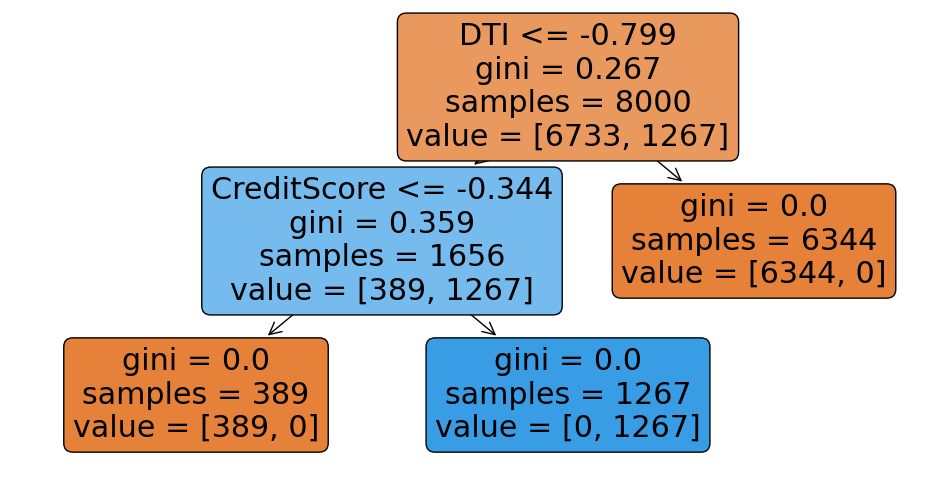

In [138]:
# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_scaled, y_train)

y_tree_pred = tree_model.predict(X_test_scaled)
accuracy_tree = accuracy_score(y_test, y_tree_pred)
print(f'Decision Tree Accuracy: {accuracy_tree}')

# Visualize the decision tree
plt.figure(figsize=(12, 6))
plot_tree(tree_model, feature_names=X.columns, filled=True, rounded=True)
plt.show()

Logistic Regression Accuracy: 0.966


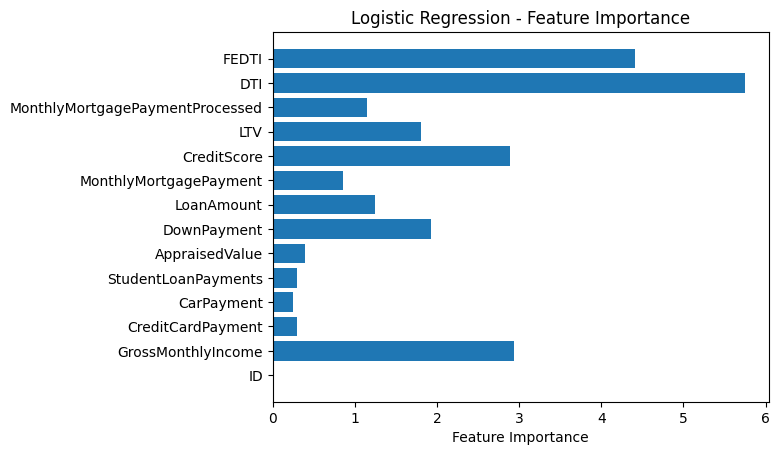

In [139]:
# Logistic Regression
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train_scaled, y_train)

# Get feature importance from logistic regression
feature_importance_logreg = np.abs(logreg_model.coef_[0])
feature_names = X.columns

y_logreg_pred = logreg_model.predict(X_test_scaled)
accuracy_logreg = accuracy_score(y_test, y_logreg_pred)
print(f'Logistic Regression Accuracy: {accuracy_logreg}')

# Plot feature importance
plt.barh(feature_names, feature_importance_logreg)
plt.xlabel('Feature Importance')
plt.title('Logistic Regression - Feature Importance')
plt.show()

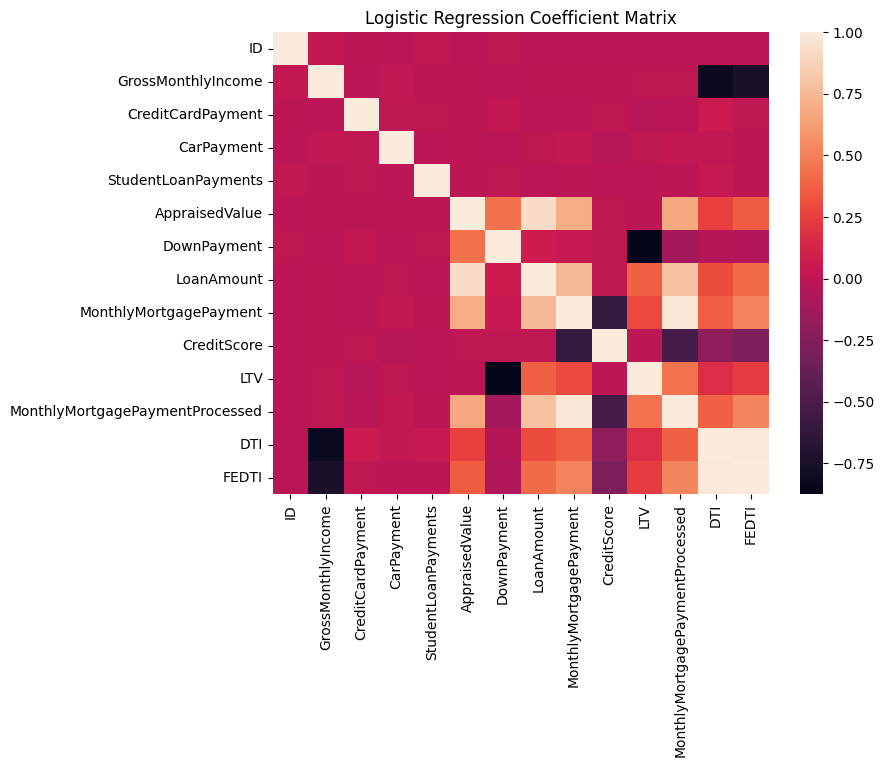

In [140]:
# Fit the Logistic Regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train_scaled, y_train)

# Get the coefficients from the model
coefficients = logreg_model.coef_[0]

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Create a minimalistic coefficient matrix plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(X.corr())
plt.title('Logistic Regression Coefficient Matrix')
plt.show()
